## Yahoo!'s Acquisition of Tumblr: Replicating a failure

_Author: Hariz Mohd Rani Hisham_

As the title above suggests, we all know where this acquisition is headed. Tumblr today is analogous of an antiquated Internet era MySpace and Blogspot.<br>
<br>
However, before we jump the gun and call out Yahoo! for pulling a corporate fumble, let's put ourselves in the shoes of Yahoo! executives and attempt to reproduce their decision-making process to the best of available knowledge. After all, this is data __*science*__, and any rigorous scientific study should be measureable and replicable.<br>
<br>
We'll be exploring data provided to us by the good people at Darden (UVA) and come up with a classic valuation model towards the end of the notebook to determine if Tumblr <s>is</s> was a good buy. I'll provide commentary along the way.<br>
<br>
Now that the stage has been set, in true Tumblr fashion, I present to you an opening GIF:

![Intro](https://mondrian.mashable.com/2013%252F05%252F19%252Ff8%252Ftumblr_mn0m.67844.gif%252Ffit-in__1200x9600.gif?signature=H1lhkwcId8PB8MTAIo3A_ETblcQ=)<br>

<div style="text-align: center"> <i>Yahoo! shows up to your door at 3AM, WWYD?</i> </div>

In [1]:
%pylab inline
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS as linear
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# thanks
import os,sys
module_path = os.path.abspath(os.path.join('C:/Users/mohdh/Documents/MSBA/Time Series/modules/'))
if module_path not in sys.path:
    sys.path.append(module_path)
import boxcox

In [3]:
path = 'C:/Users/mohdh/Documents/GitHub/yahoo-tumblr'  # <YOUR PATH>
fn = '/Spreadsheet Supplement.csv'  # <YOUR FILENAME>

__FUNctions__

In [4]:
####
# Input: text chunk extracted from file
#
# Output: List of tuples containing values of records
#
# Where used: read_file() function
####
def row_split(cont):
    measurements = None
    try:
        rows = cont.split('\n')
        rows = rows[:-1]
        measurements = [tuple(x.split(',')) for x in rows]
        return measurements
    except:
        print("Check that file contents are gucci!")
        
def read_file(path, filename):
    try:
        with open(path + filename, 'r') as f:
            cont = f.read()

        list_of_tuples = row_split(cont)

        return pd.DataFrame(list_of_tuples[1:], columns = list_of_tuples[0])
    except:
        print('Error encountered when reading in file.')

__Inital data load__

In [5]:
df = read_file(path, fn)
df = df.rename(columns = {'ï»¿People Worldwide' : 'People Worldwide'})

__Data exploration__

In [25]:
'''
Arguments: dataframe, boolean switch to enable log-transform

Output: chart output of raw data
'''
def plot_raw_data(data, logarithmic = False):
    try:
        X = np.array(data.index).tolist()
        y1 = data.iloc[:,0].astype('int')
        y2 = data.iloc[:,1].astype('int')
        
        if logarithmic:
            y1, y2 = log(y1), log(y2)

        plt.plot(X,y1,y2)
        return plt.show()
    except:
        print('The limit does not exist when plotting the data.')

For the 2 graphs below, global users are in blue and US users are in orange:

Absolute user growth over time

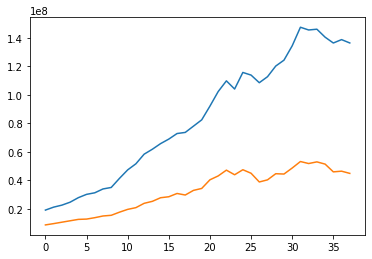

In [15]:
plot_raw_data(df)

It looks like US user growth is flatlining in later years. We might have to apply a log transformation to validate if that's true.

Logarithmic user growth over time

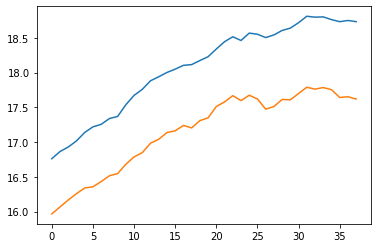

In [24]:
plot_raw_data(df, logarithmic = True)

After applying a log-transform, it looks like US users are growing at the same rate as the rest of the world.

__Q1 To infinity... and beyond!__

In [26]:
from datetime import datetime

####
# Source: https://stackoverflow.com/questions/4039879/best-way-to-find-the-months-between-two-dates
# Args: two dates in datetime() format
# 
# Output: number of months in between dates provided
####
def diff_month(d1, d2):
    return (d1.year - d2.year) * 12 + d1.month - d2.month

In [63]:
def calculate_amg(series, lookback_n, message = False):
    try:
        #ret = []
        mon_g_total = 0
        start_idx = len(series) - lookback_n
        end_idx = len(series)

        for i in range(start_idx, end_idx):
            if (i == 0) or (i == (end_idx)):
                continue

            mon_g_total += ((series[i] / series[i-1]) - 1)
            #ret.append(i)
            
        amg = mon_g_total / len(series)
        output = amg
        
        if message:
            output = 'Avg. monthly growth rate for last ' + str(lookback_n) + ' mths: %.4f' % amg + '%'
            return print(output)
        
        return output
    except:
        print('Check yoself before you wreck yoself.')

In [27]:
y1 = df['People Worldwide'].astype('int')

In [64]:
calculate_amg(y1, len(y1), message = True)

Avg. monthly growth rate for last 38 mths: 0.0547%


In [117]:
'''
Args: initial value, monthly growth rate, start year & month,
      end year & month, switch for chart

Output: n-month monthly user forecast, optional chart
'''
def average_forecast(most_recent_value,
                     growth_rate, 
                     start_yr, start_mth, end_yr, end_mth, 
                     chart = False):
    from datetime import datetime
    assert type(start_yr) == int
    assert type(start_mth) == int
    assert type(end_yr) == int
    assert type(end_mth) == int
    assert start_yr < end_yr
    try:
        lookfwd = diff_month(datetime(end_yr,end_mth,31), datetime(start_yr,start_mth,31))
        avg_forecast = most_recent_value * ((1+growth_rate) ** lookfwd)
        
        if chart:
            run = []
            current_val = most_recent_value
            for i in range(lookfwd):
                current_val = round(current_val * (1 + growth_rate),0)
                run.append(current_val)
                
            plt.plot(run)
            return plt.show()  

        return print('Projected Worldwide monthly users @ ' + str(end_mth) +\
                     '-' + str(end_yr) + ': %.0f' % avg_forecast)
    except:
        print('The forecast can\'t be calculated.')

Projected Worldwide monthly users @ 12-2022: 62548570881


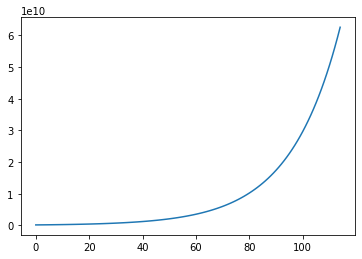

In [118]:
g = calculate_amg(y1, len(y1))
most_recent = list(df['People Worldwide'].astype('int'))[-1]

average_forecast(most_recent, g, 2013,5,2022,12)
average_forecast(most_recent, g, 2013,5,2022,12, True)

Hot dog. That's some mighty fine 10-year forecast. At this rate, Tumblr would have every living person as an active user, plus their children, and their children's children!<br>

If we assume Tumblr to keep growing at the average 38-month growth rate, the site will have __62 billion active users__.<br>

Is it realistic though?

![Mean](https://media.giphy.com/media/dSxmun8CA7TdS/giphy.gif)<br>

<div style="text-align: center"> <i>Not so fast, Cady</i> </div>

__Q2 Getting over the hype__

Recall that the average monthly growth rate over the past 38 months ~= 5.4%

In [127]:
calculate_amg(y1, 38, True)
calculate_amg(y1, 12, True)

Avg. monthly growth rate for last 38 mths: 0.0547%
Avg. monthly growth rate for last 12 mths: 0.0051%


Average monthly growth in the last 12 months as sharply decrease to 0.5%.<br>
<br>
Hold up, so you're telling me we're not growing as quickly as when we were popular???

__Q3 Smooth operator... smoo-oo-ooth operator__

Boxcox

Adapted from Dan Trepanier, _3.1 Stochastic Processes_

Sampling       :  26 / 38
Box Cox lambda : 0.30729741915317116


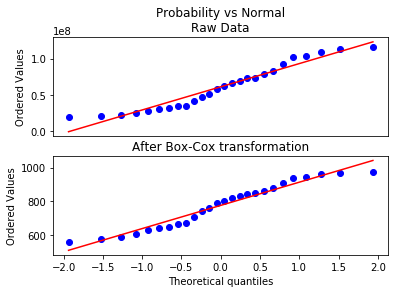


Box Cox Transform lambda : 0.307297
+---------+-------------------+--------------------+---------------------+
|   data  |        mean       |       st_dev       |     std to mean     |
+---------+-------------------+--------------------+---------------------+
|   Raw   | 60953419.84615385 | 31039970.525462862 |  0.5092408367538295 |
| Box Cox | 775.6004264408741 | 131.89185733697073 | 0.17005129553912793 |
+---------+-------------------+--------------------+---------------------+


In [128]:
bc = boxcox.BoxCox(y1, test_size=.3)
bc.plot()

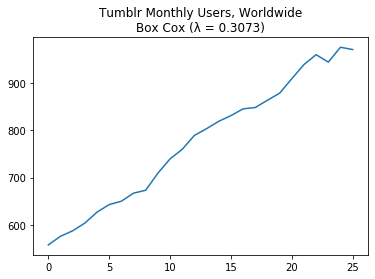

In [149]:
plt.plot(bc.Y)
plt.title('Tumblr Monthly Users, Worldwide\nBox Cox (λ = %6.4f)' % bc.lbda)
plt.show()

##### Fitting models to the data:

In [134]:
y2 = pd.DataFrame(bc.Y)[0]

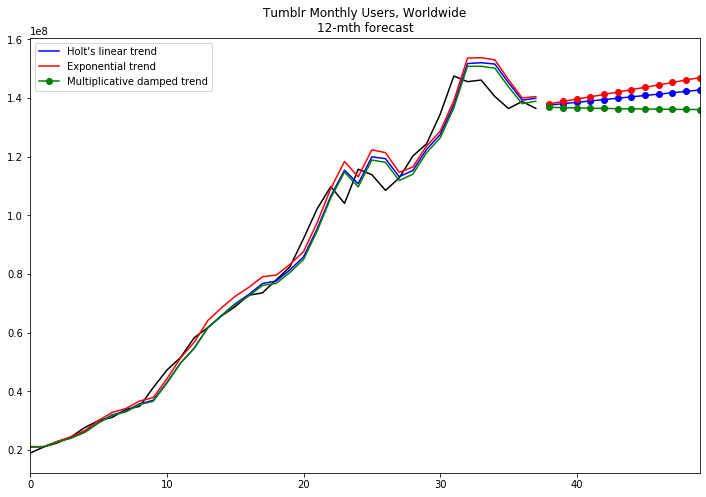

In [160]:
# adapted from https://www.statsmodels.org/dev/examples/notebooks/generated/exponential_smoothing.html

fit1 = Holt(y1).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(12).rename("Holt's linear trend")
fit2 = Holt(y1, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(12).rename("Exponential trend")
fit3 = Holt(y1, exponential=True, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(12).rename("Multiplicative damped trend")

ax = y1.plot(color="black", figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker="o", legend=True)

plt.title('Tumblr Monthly Users, Worldwide\n12-mth forecast')
plt.show()

![itsalive](https://media.giphy.com/media/UqUJhrD0om73q/giphy.gif)<br>

<div style="text-align: center"> <i>My actual reaction to the above output</i> </div>

Let's look at the root mean squared errors (RMSE) for each of these models:

In [137]:
from sklearn.metrics import mean_squared_error

rmse1 = sqrt(mean_squared_error(fit1.fittedvalues, y1))
rmse2 = sqrt(mean_squared_error(fit2.fittedvalues, y1))
rmse3 = sqrt(mean_squared_error(fit3.fittedvalues, y1))
print('RMSE Linear: %.2f' % rmse1)
print('RMSE Exponential: %.2f' % rmse2)
print('RMSE Multiplicative Damped: %.2f' % rmse3)

RMSE Linear: 4958041.49
RMSE Exponential: 5399986.27
RMSE Multiplicative Damped: 4880251.54


After comparing the RMSE across the 3 models, the Multiplicative Damped Trend Model gave us the lowest RMSE, indicating that this model fitted our data best. Downstream, we will use this model to estimate cash flows.

__Q4 Cloudy with a Chance of Diminishing Returns__

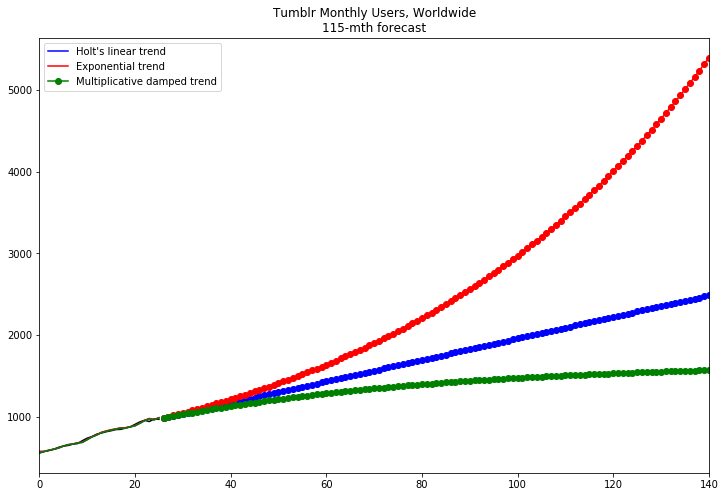

In [261]:
fit1 = Holt(y2).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast1 = fit1.forecast(115).rename("Holt's linear trend")
fit2 = Holt(y2, exponential=True).fit(smoothing_level=0.8, smoothing_slope=0.2, optimized=False)
fcast2 = fit2.forecast(115).rename("Exponential trend")
fit3 = Holt(y2, exponential=False, damped=True).fit(smoothing_level=0.8, smoothing_slope=0.2)
fcast3 = fit3.forecast(115).rename("Multiplicative damped trend")

ax = y2.plot(color="black", figsize=(12,8))
fit1.fittedvalues.plot(ax=ax, color='blue')
fcast1.plot(ax=ax, color='blue', marker="o", legend=True)
fit2.fittedvalues.plot(ax=ax, color='red')
fcast2.plot(ax=ax, color='red', marker="o", legend=True)
fit3.fittedvalues.plot(ax=ax, color='green')
fcast3.plot(ax=ax, color='green', marker="o", legend=True)

plt.title('Tumblr Monthly Users, Worldwide\n115-mth forecast')
plt.show()

Outstanding. Why didn't they teach us this math in high school?

![Wow](https://media.giphy.com/media/BmmfETghGOPrW/giphy.gif)<br>

<div style="text-align: center"> <i>My brain when I ran the cell above</i> </div>

Since we applied a BoxCox transformation to our data, we'll have to first undo the transformation to retrieve the forecasts for the next 115 months.

__Q5 Money matters__

In [ ]:
(list(y1)[-1] / list(y1)[-13]) ** (1/12) - 1

In [164]:
'''
Arguments: annual cash flows, no. of periods, anualized rate of return

Where used: Here, and only here

Output: scalar value of discounted cash flow valuation
'''
def dcf(cash_flows, periods, rate):
    assert type(periods) == int
    assert type(rate) == float
    assert len(cash_flows) == periods
    try:
        dcf = 0
        yr = 0
        for i in range(len(cash_flows)):
            dcf = cash_flows[i] / ((1 + rate) ** i+1)
        return dcf
    except:
        print('DCF calculation failure.')

In [165]:
ww_growth = 0.0152
us_decline = 0.0167
p2u_equiv = 2.0
us_rue_inc = 0.30
ww_rue_inc = 0.03
cash_margin = 0.317
eng_mult = 4.5
r = 0.1
g = 0.03

In [235]:
fcast = round(fcast3,0).reset_index(drop = True)

In [166]:
fcast = fcast3.reset_index(drop = True)

In [236]:
fcast.iloc[-1,]

138392434.0

Custom script to create year range

In [237]:
years = []
start_yr = 2013
end_yr = 2022
ranj = end_yr - start_yr
for i in range(len(fcast)):
    if start_yr == end_yr:
        continue
    if i < 7:
        years.append(start_yr)
    else:
        for j in range(12):
            years.append(start_yr+1)
        start_yr += 1

In [238]:
ppl_ww_fcast = pd.concat([fcast,pd.Series(years)], axis = 1).rename(columns = {'Additive damped trend' : 'Users',
                                                                               0 : 'Year'})

In [239]:
tbl = ppl_ww_fcast.groupby('Year').mean().reset_index(drop = False).copy()

In [243]:
tbl['Multiplicative damped trend'] = tbl['Multiplicative damped trend'].astype('int')

In [175]:
ww13 = np.mean(fcast[:7])
pct_us = 0.33
us_ppl = pct_us * ww13
row_ppl = ww13 - us_ppl
ue_us = us_ppl / p2u_equiv
ue_row = row_ppl / p2u_equiv
revenue = (ue_us * 13.58 + ue_row * 3.21) / eng_mult * 7/12
opex = revenue * cash_margin
cf = revenue - opex
print(str(cf))

40296711.42660536


In [245]:
'''
Things that are constant
'''
ww_growth = 0.0152
us_decline = 0.0167
p2u_equiv = 2.0
us_rue_inc = 0.30
row_rue_inc = 0.03
cash_margin = 0.317
eng_mult = 4.5
r = 0.1
g = 0.03

In [257]:
ww13 = tbl.iloc[0,1]

In [258]:
'''
Things that change
'''
pct_us = 0.33
us_ppl = pct_us * tbl.iloc[0,1]
row_ppl = ww13 - us_ppl
ue_us = us_ppl / p2u_equiv
ue_row = row_ppl / p2u_equiv

fb_rpu_us = 13.58
fb_rpu_row = 3.21

dcf = []

for i in range(len(tbl)):
    revenue = 0
    opex = 0
    cf = 0
    
    us_ppl = pct_us * tbl.iloc[i,1]
    row_ppl = tbl.iloc[i,1] - us_ppl
    ue_us = us_ppl / p2u_equiv
    ue_row = row_ppl / p2u_equiv
    
    revenue = (ue_us * fb_rpu_us + ue_row * fb_rpu_row) / eng_mult
    
    if tbl.iloc[i,0] == 2013:
        revenue = (ue_us * fb_rpu_us + ue_row * fb_rpu_row) / eng_mult * 7/12
    
    opcf = revenue * cash_margin
    
    if tbl.iloc[i,0] == 2022:
        terminal = opcf * (1+g) / (r-g)
        opcf += terminal
        
    pv = opcf / ((1+r) ** (i+1))
    
    dcf.append(pv)
    
    pct_us -= us_decline
    fb_rpu_us += us_rue_inc
    fb_rpu_row += row_rue_inc

In [204]:
(144.9267 + (144.9267 * (1+g) / (r-g))) / ((1+r) ** 10)

878.0438329797652

In [260]:
sum(dcf)

336819868.6664794

Recall that the Yahoo! team initally acquired Tumblr at $1.1 billion. That's billions with a __B__.

![Jim](https://media.giphy.com/media/BQL6Sj8iXRP3O/giphy.gif)

__Conclusion__

So should Yahoo! have bought Tumblr after all? In true Tumblr GIF fashion, here's my verdict:

![Decision](https://mondrian.mashable.com/2013%252F05%252F19%252Ff8%252Ftumblr_mn0m.0feaf.gif%252Ffit-in__1200x9600.gif?signature=S68Hf3LNEs7MPtxehff0ToYVwhw=)

__Introducing lagged variables__

Below is a nifty function to create lag variables very quickly:

In [ ]:
def lag_variables(series, n, prefix = ''):
    ####
    # Input: series, n = number of lags
    # 
    # Output: list of tuples containing lag variables
    #
    # Downstream: to be added into main dataframe component for 
    #             further analysis / manipulation
    ####
    import pandas as pd
    assert n > 0
    try:
        temp_list = []
        col_d = {}
        for i in range(n):
            temp_list.append(tuple(series.shift(i + 1).tolist()))
            key = i
            col_name = 'lag' + str(i+1)
            
            if len(prefix) > 0:
                to_append = str(prefix) + '_'
                col_name = to_append + col_name
            
            if key not in col_d:
                col_d[i] = col_name
                
        df = pd.DataFrame(temp_list).transpose().rename(columns = col_d)
        
        return df
    except:
        print('Something went wrong when lagging variables.')
    